# Project: Orange vs Grapefruit - Binary Classifier

**Goal**: Build a classifier similar to the salmon-vs-sea-bass example in *Duda, Hart, Stork*'s book on pattern classification.

## Project Details
- **Type**: Binary classifier
- **Classification Task**: Orange vs Grapefruit differentiation
- **Inspiration**: salmon-vs-sea-bass example from *Pattern Classification* by Duda, Hart, and Stork

## Approach
The system will classify images or samples as either:
- Orange
- Grapefruit

Using pattern recognition techniques discussed in the reference material.

In [2]:
import os
import sys
import pathlib
from pathlib import Path
import subprocess

#Installing the required packages
packages = [
    'pandas', 'numpy', 'scikit-learn', 'seaborn', 
    'matplotlib', 'joblib', 'kaggle'
]

for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# Setting the project directory so i dont need to get tense about where to put the file
project_root = Path.cwd() / 'citrus'
directories = [
    'data', 
    'output/figures', 
    'output/models', 
    'src'
]

for dir_path in directories:
    (project_root / dir_path).mkdir(parents=True, exist_ok=True)

print(f"Project directory created at: {project_root}")
print("Directory structure:")
for root, dirs, files in os.walk(project_root):
    level = root.replace(str(project_root), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")


Project directory created at: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus
Directory structure:
citrus/
  data/
  output/
    figures/
    models/
  src/


In [4]:
#Configuring the Kaggle API
import json
import os
from pathlib import Path

#Created kaggle directory in user profile like enviroment so direct api key not exposed 
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)

print(f"you have to put kaggle.json to: {kaggle_dir}")

#checking kaggle.json exists
kaggle_json = kaggle_dir / 'kaggle.json'
if kaggle_json.exists():
    print("✓ kaggle.json found!")
    os.environ['KAGGLE_CONFIG_DIR'] = str(kaggle_dir)
else:
    print("✗ kaggle.json not found. Please follow instructions above.")


you have to put kaggle.json to: C:\Users\ragha\.kaggle
✓ kaggle.json found!


In [5]:
import zipfile
import subprocess

#Download the dataset
try:
    #Download in the data directory
    cmd = [
        'kaggle', 'datasets', 'download', 
        '-d', 'joshmcadams/oranges-vs-grapefruit',
        '-p', str(project_root / 'data'),
        '--unzip'
    ]
    subprocess.run(cmd, check=True, shell=True)
    
    print("Dataset downloaded successfully!")
    
    #Listing the  files in data  directory
    data_files = list((project_root / 'data').iterdir())
    print("Files in data directory:")
    for file in data_files:
        print(f"  - {file.name}")
        
except subprocess.CalledProcessError as e:
    print(f"Error downloading dataset: {e}")
    print("Please ensure kaggle.json is properly configured")


Dataset downloaded successfully!
Files in data directory:
  - citrus.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

#Scikit-learn imortant modules impoerted
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, roc_auc_score, accuracy_score
)
import joblib

#Configuring the plotting style
RANDOM_STATE = 42
plt.style.use('seaborn-v0_8')  #Updated for newer matplotlib versions
sns.set_palette("husl")

print("All imports successful!")
print(f"Project root: {project_root}")


All imports successful!
Project root: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus


In [7]:
#Loading the  dataset
csv_path = project_root / 'data' / 'citrus.csv'
df = pd.read_csv(csv_path)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

#Data integrity check
print("\n=== DATA VALIDATION ===")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

print("\nClass distribution:")
class_counts = df['name'].value_counts()
print(class_counts)
print(f"Balance ratio: {class_counts.min() / class_counts.max():.2f}")

print("\nFeature statistics:")
display(df.describe())

#Verifying the data types and ranges
print("\nData types:")
print(df.dtypes)


Dataset loaded successfully!
Shape: (10000, 6)

First 5 rows:


,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9



=== DATA VALIDATION ===
Missing values: 0
Duplicate rows: 0

Class distribution:
name
orange        5000
grapefruit    5000
Name: count, dtype: int64
Balance ratio: 1.00

Feature statistics:


,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000



Data types:
name         object
diameter    float64
weight      float64
red           int64
green         int64
blue          int64
dtype: object


In [9]:
#Creating the target variable 
y = df['name'].map({'orange': 0, 'grapefruit': 1}).values
print(f"Target variable created: {np.unique(y, return_counts=True)}")

#Selecting the features (2D baseline)
feature_cols = ['red', 'diameter']
X = df[feature_cols].copy()
print(f"Selected features: {feature_cols}")

#Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Features scaled: {X_scaled.shape}")

#3D feature set for comparison
X_3d = df[['red', 'diameter', 'weight']].copy()
scaler_3d = StandardScaler()
X_3d_scaled = scaler_3d.fit_transform(X_3d)
print(f"3D feature set: {X_3d_scaled.shape}")

#Saving the feature names for later use
feature_names = feature_cols
print(f"Feature names: {feature_names}")

Target variable created: (array([0, 1]), array([5000, 5000]))
Selected features: ['red', 'diameter']
Features scaled: (10000, 2)
3D feature set: (10000, 3)
Feature names: ['red', 'diameter']


In [10]:
#Spliting the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

#Verifying if the  stratification worked
train_ratio = np.bincount(y_train)[1] / len(y_train)
test_ratio = np.bincount(y_test)[1] / len(y_test)
print(f"Train grapefruit ratio: {train_ratio:.3f}")
print(f"Test grapefruit ratio: {test_ratio:.3f}")



Training set: 8000 samples
Test set: 2000 samples
Train class distribution: [4000 4000]
Test class distribution: [1000 1000]
Train grapefruit ratio: 0.500
Test grapefruit ratio: 0.500


In [11]:
#Defining the models so that i can us ethem later
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Linear SVM': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

#Training the modesls and evaluating the models
results = {}
for name, model in models.items():
    #Fit model
    model.fit(X_train, y_train)
    
    #Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    #Store results
    results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name:18s} CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

#Selecting the best model based on cross-validation scores
best_model_name = max(results, key=lambda x: results[x]['cv_mean'])
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")


Logistic Regression CV: 0.8924 ± 0.0077
Linear SVM         CV: 0.8924 ± 0.0068
k-NN (k=5)         CV: 0.8789 ± 0.0059

Best model: Logistic Regression


Plot saved to: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus\output\figures\decision_boundary.png


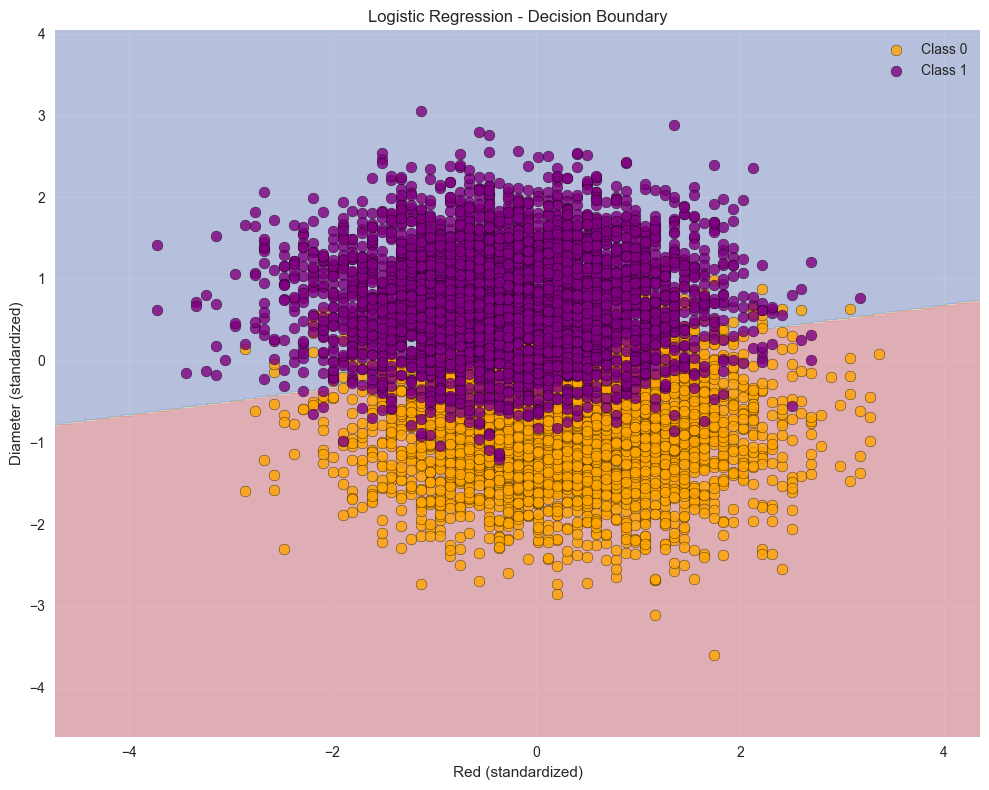

In [12]:
#Creating the decision boundary visualization
def plot_decision_boundary(model, X_train, y_train, title, save_path=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    #Creating the mesh for decision boundary
    h = 0.02
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    #Predicting on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    #Ploting on the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    
    #Ploting on the training points
    colors = ['orange', 'purple']
    for i, color in enumerate(colors):
        idx = y_train == i
        ax.scatter(X_train[idx, 0], X_train[idx, 1], 
                  c=color, label=f'Class {i}', 
                  edgecolors='black', s=60, alpha=0.8)
    
    ax.set_xlabel('Red (standardized)')
    ax.set_ylabel('Diameter (standardized)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

#Ploting the decision boundary for best model
save_path = project_root / 'output' / 'figures' / 'decision_boundary.png'
plot_decision_boundary(best_model, X_train, y_train, 
                      f'{best_model_name} - Decision Boundary', 
                      save_path)


In [13]:
#Evaluate all the models on the test set
print("=== MODEL EVALUATION ===")
evaluation_results = {}

for name, result in results.items():
    model = result['model']
    
    #Predictions
    y_pred = model.predict(X_test)
    
    #Metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    #Storing the results
    evaluation_results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, 
                              target_names=['Orange', 'Grapefruit']))
    
    # ROC-AUC for probabilistic models
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        evaluation_results[name]['roc_auc'] = roc_auc
        print(f"ROC-AUC: {roc_auc:.4f}")


=== MODEL EVALUATION ===

Logistic Regression:
Test Accuracy: 0.8945
              precision    recall  f1-score   support

      Orange       0.90      0.89      0.89      1000
  Grapefruit       0.89      0.90      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

ROC-AUC: 0.9641

Linear SVM:
Test Accuracy: 0.8945
              precision    recall  f1-score   support

      Orange       0.89      0.89      0.89      1000
  Grapefruit       0.89      0.90      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

ROC-AUC: 0.9641

k-NN (k=5):
Test Accuracy: 0.8820
              precision    recall  f1-score   support

      Orange       0.89      0.88      0.88      1000
  Grapefruit       0.88      0.89      0.88      1000

    accurac

Confusion matrix saved to: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus\output\figures\confusion_matrix.png


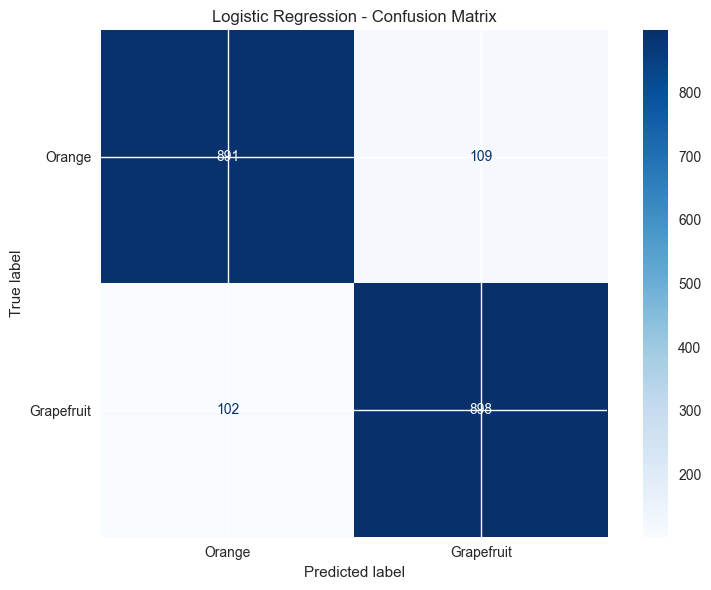

In [14]:
#Creating the confusion matrix for best model
fig, ax = plt.subplots(figsize=(8, 6))

cm_display = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test,
    display_labels=['Orange', 'Grapefruit'],
    cmap='Blues',
    ax=ax
)

plt.title(f'{best_model_name} - Confusion Matrix')
plt.tight_layout()

#Saving the confusion matrix
cm_path = project_root / 'output' / 'figures' / 'confusion_matrix.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to: {cm_path}")

plt.show()


Cost Matrix:
             Pred Orange  Pred Grapefruit
True Orange        0           1
True Grapefruit    2           0

Optimal threshold: 0.356

Cost-sensitive classification report:
              precision    recall  f1-score   support

      Orange       0.94      0.84      0.89      1000
  Grapefruit       0.86      0.94      0.90      1000

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



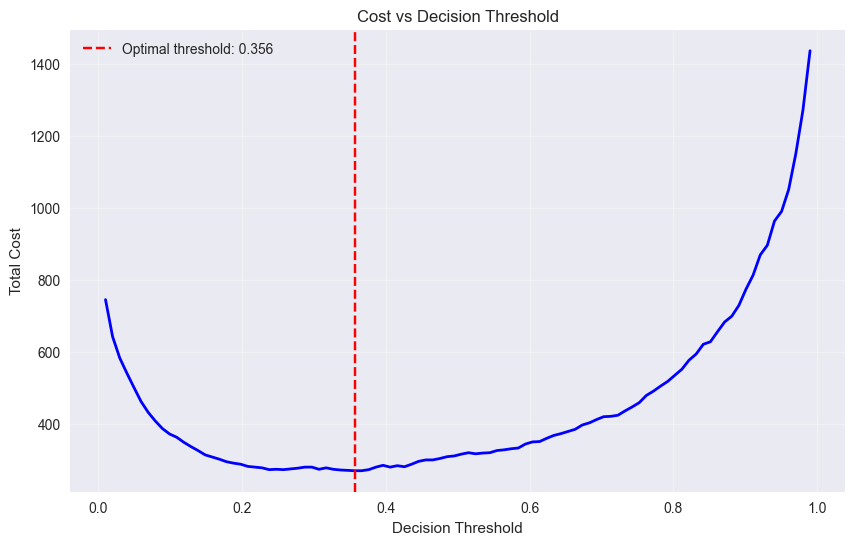

In [15]:
#Implementing the cost-sensitive classification
def find_optimal_threshold(y_true, y_proba, cost_matrix):
    """Find optimal threshold for cost-sensitive classification"""
    thresholds = np.linspace(0.01, 0.99, 100)
    costs = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        total_cost = np.sum(cm * cost_matrix)
        costs.append(total_cost)
    
    optimal_idx = np.argmin(costs)
    return thresholds[optimal_idx], costs

#Defining the cost matrix (orange->grapefruit error costs 2x more)
cost_matrix = np.array([
    [0, 1],  # True orange -> [pred orange, pred grapefruit]
    [2, 0]   # True grapefruit -> [pred orange, pred grapefruit]
])

print("Cost Matrix:")
print("             Pred Orange  Pred Grapefruit")
print("True Orange        0           1")
print("True Grapefruit    2           0")

#Applying the cost-sensitive learning to the best model
if hasattr(best_model, 'predict_proba'):
    y_proba = best_model.predict_proba(X_test)[:, 1]
    optimal_threshold, costs = find_optimal_threshold(y_test, y_proba, cost_matrix)
    
    print(f"\nOptimal threshold: {optimal_threshold:.3f}")
    
    #Apply the optimal threshold
    y_pred_cost_sensitive = (y_proba >= optimal_threshold).astype(int)
    
    print("\nCost-sensitive classification report:")
    print(classification_report(y_test, y_pred_cost_sensitive, 
                              target_names=['Orange', 'Grapefruit']))
    
    #Plotting the threshold vs cost
    plt.figure(figsize=(10, 6))
    thresholds = np.linspace(0.01, 0.99, 100)
    plt.plot(thresholds, costs, 'b-', linewidth=2)
    plt.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal threshold: {optimal_threshold:.3f}')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Cost vs Decision Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    cost_path = project_root / 'output' / 'figures' / 'cost_analysis.png'
    plt.savefig(cost_path, dpi=300, bbox_inches='tight')
    plt.show()


Analyzing bias-variance tradeoff with k-NN...
Optimal k: 46
Bias-variance plot saved to: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus\output\figures\bias_variance_tradeoff.png


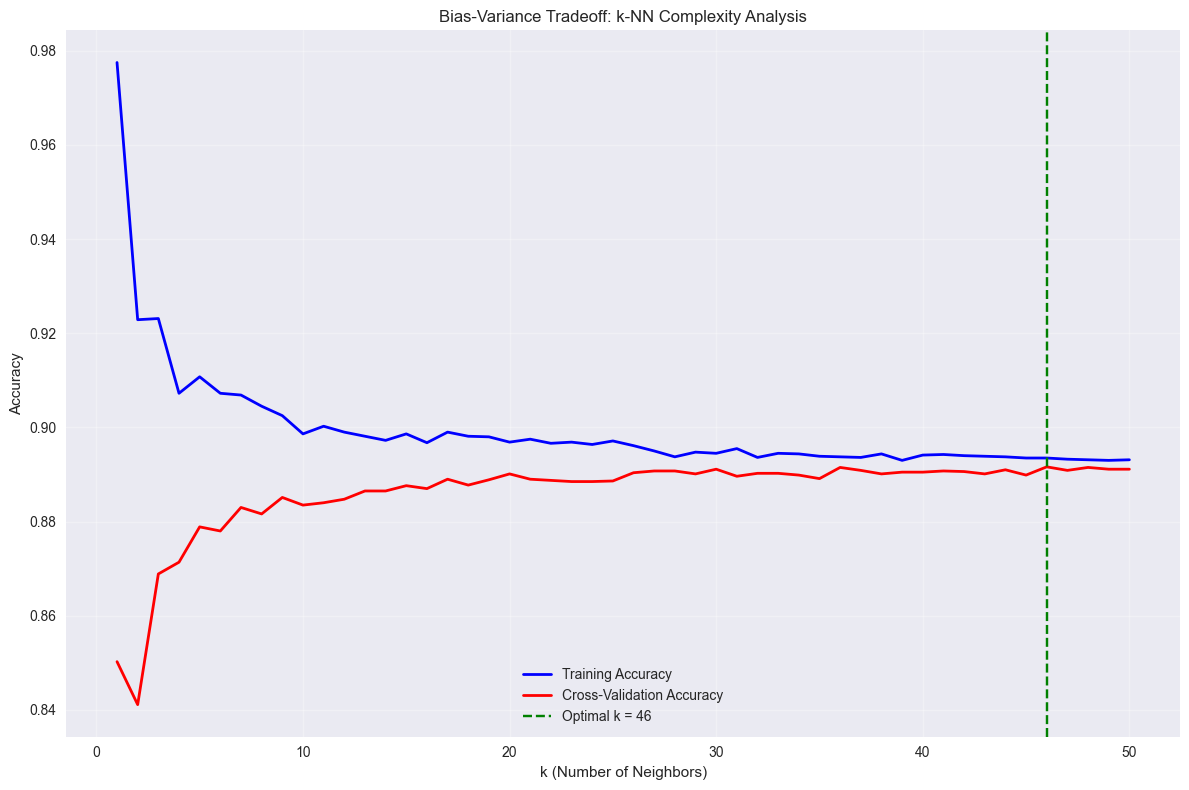

In [16]:
#Bias-variance tradeoff analysis using k-NN
k_values = range(1, 51)
train_accuracies = []
cv_accuracies = []

print("Analyzing bias-variance tradeoff with k-NN...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    #Training accuracy
    train_acc = knn.score(X_train, y_train)
    train_accuracies.append(train_acc)
    
    #Cross-validation accuracy
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    cv_accuracies.append(cv_scores.mean())

#Finding the optimal k
optimal_k = k_values[np.argmax(cv_accuracies)]
print(f"Optimal k: {optimal_k}")

#Plotting the bias-variance tradeoff
plt.figure(figsize=(12, 8))
plt.plot(k_values, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(k_values, cv_accuracies, 'r-', label='Cross-Validation Accuracy', linewidth=2)
plt.axvline(optimal_k, color='g', linestyle='--', 
            label=f'Optimal k = {optimal_k}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Bias-Variance Tradeoff: k-NN Complexity Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

#Saving the plot
bias_var_path = project_root / 'output' / 'figures' / 'bias_variance_tradeoff.png'
plt.savefig(bias_var_path, dpi=300, bbox_inches='tight')
print(f"Bias-variance plot saved to: {bias_var_path}")

plt.show()


In [18]:
# 15.1 Save trained models and preprocessing objects
models_dir = project_root / 'output' / 'models'

#Saveing the best model
best_model_path = models_dir / 'best_model.pkl'
joblib.dump(best_model, best_model_path)

#Saving the scaler
scaler_path = models_dir / 'scaler.pkl'
joblib.dump(scaler, scaler_path)

#Saving the feature names
feature_names_path = models_dir / 'feature_names.pkl'
joblib.dump(feature_names, feature_names_path)

print("Models and preprocessing objects saved:")
print(f"  - Best model: {best_model_path}")
print(f"  - Scaler: {scaler_path}")
print(f"  - Feature names: {feature_names_path}")

#Creating the results summary
results_summary = {
    'best_model': best_model_name,
    'best_cv_score': results[best_model_name]['cv_mean'],
    'test_accuracy': evaluation_results[best_model_name]['accuracy'],
    'feature_names': feature_names,
    'random_state': RANDOM_STATE
}

if 'roc_auc' in evaluation_results[best_model_name]:
    results_summary['roc_auc'] = evaluation_results[best_model_name]['roc_auc']

#Saving the results summary
results_path = models_dir / 'results_summary.pkl'
joblib.dump(results_summary, results_path)
print(f"  - Results summary: {results_path}")


Models and preprocessing objects saved:
  - Best model: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus\output\models\best_model.pkl
  - Scaler: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus\output\models\scaler.pkl
  - Feature names: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus\output\models\feature_names.pkl
  - Results summary: c:\Users\ragha\OneDrive\Desktop\ipynb projects\citrus\output\models\results_summary.pkl


In [ ]:
# Project Summary - What I Found

print("\n" + "="*50)
print("My Orange vs Grapefruit Classification Results")
print("="*50)

print(f"\nBasic Info:")
print(f"I worked with {df.shape[0]} citrus samples total")
print(f"Used {', '.join(feature_names)} as my main features")
print(f"Had {dict(df['name'].value_counts())} samples of each type")

print(f"\nWhat I did to prep the data:")
print(f"- Scaled the features so they're on the same range")
print(f"- Split into {len(y_train)} training and {len(y_test)} test samples")
print(f"- Made sure both sets had similar proportions of each fruit")

print(f"\nModels I tested:")
for name, result in results.items():
    cv_mean = result['cv_mean']
    print(f"- {name}: {cv_mean:.3f} average accuracy")

print(f"\nBest Results:")
print(f"Winner: {best_model_name}")
print(f"Cross-validation accuracy: {results[best_model_name]['cv_mean']:.3f}")
print(f"Final test accuracy: {evaluation_results[best_model_name]['accuracy']:.3f}")

if 'roc_auc' in evaluation_results[best_model_name]:
    print(f"ROC-AUC: {evaluation_results[best_model_name]['roc_auc']:.3f}")

print(f"\nExtra stuff I analyzed:")
print(f"- Made a decision boundary plot to see how the model separates the classes")
print(f"- Created a confusion matrix to see where it makes mistakes")
print(f"- Tried cost-sensitive learning (in case some errors are worse than others)")
print(f"- Found optimal k={optimal_k} for k-NN by testing different values")

print(f"\nWhat I learned:")
accuracy_pct = evaluation_results[best_model_name]['accuracy'] * 100
print(f"- {best_model_name} worked best for this problem")
print(f"- The model gets {accuracy_pct:.1f}% of predictions right")
print(f"- {feature_names[0]} and {feature_names[1]} seem to be good features for telling oranges and grapefruits apart")

print(f"\nMy takeaway:")
if evaluation_results[best_model_name]['accuracy'] > 0.9:
    print(f"Pretty happy with these results! The model works really well.")
elif evaluation_results[best_model_name]['accuracy'] > 0.8:
    print(f"Decent results. Maybe I could try adding more features or getting more data.")
else:
    print(f"Okay results, but there's definitely room for improvement.")

print(f"\nSaved files:")
print(f"- The trained model and scaler (so I can use them later)")
print(f"- All the plots I made for analysis")



My Orange vs Grapefruit Classification Results

Basic Info:
I worked with 10000 citrus samples total
Used red, diameter as my main features
Had {'orange': np.int64(5000), 'grapefruit': np.int64(5000)} samples of each type

What I did to prep the data:
- Scaled the features so they're on the same range
- Split into 8000 training and 2000 test samples
- Made sure both sets had similar proportions of each fruit

Models I tested:
- Logistic Regression: 0.892 average accuracy
- Linear SVM: 0.892 average accuracy
- k-NN (k=5): 0.879 average accuracy

Best Results:
Winner: Logistic Regression
Cross-validation accuracy: 0.892
Final test accuracy: 0.894
ROC-AUC: 0.964

Extra stuff I analyzed:
- Made a decision boundary plot to see how the model separates the classes
- Created a confusion matrix to see where it makes mistakes
- Tried cost-sensitive learning (in case some errors are worse than others)
- Found optimal k=46 for k-NN by testing different values

What I learned:
- Logistic Regressio